## Reproduction on CIFAR-10

## Mount Google Drive

Mounts Google Drive to access the project directory and persist files across sessions.

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


## Define Base and Data Directories

Sets the root directory for the project and defines the path for CIFAR-10 data storage.


In [4]:
BASE_DIR = '/content/drive/MyDrive/deep_learning_project'
DATA_DIR = os.path.join(BASE_DIR, 'data', 'CIFAR10')
ACTIVATIONS = ['ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh', 'ELU', 'Swish_fixed', 'Swish_trainable']
MODELS = ['ResNet20', 'CustomCNN', 'DenseNet121', 'WideResNet50']

# Create necessary directories
os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
for act in ACTIVATIONS:
    os.makedirs(os.path.join(BASE_DIR, act), exist_ok=True)

## Import PyTorch and TorchVision Libraries

Imports essential modules for building models, training, and data augmentation.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import densenet121, wide_resnet50_2
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from tqdm import tqdm
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preparation for CIFAR-10

Defines data augmentation and normalization for training and test datasets.


In [ ]:
# Data Preparation for CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
])

trainset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testset  = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transform_test)
test_loader  = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

## Define Custom Activation Functions

Implements Swish (fixed and trainable β) for experimentation.


In [7]:
# Define Activation Functions
class SwishFixed(nn.Module):
    def forward(self, x): return x * torch.sigmoid(x)
class SwishTrainable(nn.Module):
    def __init__(self):
        super().__init__(); self.beta = nn.Parameter(torch.tensor(1.0))
    def forward(self, x): return x * torch.sigmoid(self.beta * x)

activation_map = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(0.1),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'ELU': nn.ELU(),
    'Swish_fixed': SwishFixed(),
    'Swish_trainable': SwishTrainable()
}

## Define Model Architectures

Implements ResNet-20 using BasicBlock components, supporting flexible activation insertion.


In [8]:
# Define Model Architectures
# ResNet-20
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, activation, stride=1):
        super().__init__()
        self.act = activation
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.act(out)
        return out

class ResNet20(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.act = activation
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 3, activation, 1)
        self.layer2 = self._make_layer(32, 3, activation, 2)
        self.layer3 = self._make_layer(64, 3, activation, 2)
        self.linear = nn.Linear(64, 10)
    def _make_layer(self, planes, num_blocks, activation, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_planes, planes, activation, s))
            self.in_planes = planes
        return nn.Sequential(*layers)
    def forward(self, x):
        out = self.act(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1).view(out.size(0), -1)
        return self.linear(out)

# Custom CNN
class CustomCNN(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.act = activation
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.fc1   = nn.Linear(128*4*4, 256)
        self.fc2   = nn.Linear(256, 10)
    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = self.pool(self.act(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        return self.fc2(x)

# DenseNet121
class DenseNet121Custom(nn.Module):
    def __init__(self, activation, num_classes=10):
        super().__init__()
        self.model = densenet121(pretrained=True)
        def replace_relu(mod):
            for name, child in mod.named_children():
                if isinstance(child, nn.ReLU):
                    setattr(mod, name, activation)
                else:
                    replace_relu(child)
        replace_relu(self.model.features)
        in_feats = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_feats, num_classes)

    def forward(self, x):
        return self.model(x)


# WideResNet50_2
class WideResNet50Custom(nn.Module):
    def __init__(self, activation, num_classes=10):
        super().__init__()
        self.model = wide_resnet50_2(pretrained=True)
        def replace_relu(mod):
            for name, child in mod.named_children():
                if isinstance(child, nn.ReLU):
                    setattr(mod, name, activation)
                else:
                    replace_relu(child)
        replace_relu(self.model)
        in_feats = self.model.fc.in_features
        self.model.fc = nn.Linear(in_feats, num_classes)

    def forward(self, x):
        return self.model(x)

## Training and Evaluation Utilities

Defines the validation function that computes Top-1 and Top-5 accuracy and average loss.


In [9]:
# Training & Evaluation Functions

def validate(model, loader, criterion):
    model.eval(); total_loss=correct=total=0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x); loss = criterion(out,y)
            total_loss += loss.item()*x.size(0)
            preds = out.argmax(1); correct += preds.eq(y).sum().item(); total+=y.size(0)
    return total_loss/total, 100.*correct/total

## CIFAR-10 Experiment Loop: Model Training, Validation, and Saving

This cell executes the full training pipeline for a selected model-activation pair on the CIFAR-10 dataset.

### Configuration
- `SELECT_MODEL`: Choose from `'ResNet20'`, `'CustomCNN'`, `'DenseNet121'`, `'WideResNet50'`
- `SELECT_ACTIVATION`: Choose from predefined activations such as `'ReLU'`, `'Swish_trainable'`, `'Tanh'`, etc.

### Model Instantiation
The selected model is instantiated with the corresponding activation function from `activation_map`, and moved to the configured device (GPU or CPU).

### Optimization Setup
- **Loss Function**: `CrossEntropyLoss` for multi-class classification
- **Optimizer**: SGD with momentum (0.9), weight decay (5e-4), and Nesterov acceleration
- **Scheduler**: Cosine annealing schedule over 200 cycles

### Training Loop
- Trains the model for `NUM_EPOCHS = 50`
- Uses `tqdm` for per-epoch progress visualization with real-time loss, accuracy, and ETA
- Tracks training and validation metrics in the `history` dictionary:
  - `train_loss`, `train_acc`: Averaged over batches
  - `val_loss`, `val_acc`: Computed using the `validate()` function

### Saving Artifacts
- Trained model weights are saved to:  
  `BASE_DIR / <activation> / CIFAR10_<model>_<activation>.pth`
- Training history (as a Python dictionary) is saved to:  
  `BASE_DIR / <activation> / history_<model>_<activation>.pt`

These saved artifacts allow for reproducibility and later analysis or visualization of model performance across different activation functions.



In [ ]:
# Experiment Loop for CIFAR-10 with Per-Epoch Progress Bars
# Manually choose one model and one activation for flexibility:
SELECT_MODEL = 'ResNet20'         # options: ResNet20, CustomCNN, MLP, MobileNetV2
SELECT_ACTIVATION = 'Tanh'  # pick from ACTIVATIONS list

model = {
    'ResNet20': ResNet20(activation_map[SELECT_ACTIVATION]),
    'CustomCNN': CustomCNN(activation_map[SELECT_ACTIVATION]),
    'DenseNet121' : DenseNet121Custom(activation_map[SELECT_ACTIVATION], num_classes=10),
    'WideResNet50': WideResNet50Custom(activation_map[SELECT_ACTIVATION], num_classes=10)
}[SELECT_MODEL].to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = CosineAnnealingLR(optimizer, T_max=200)

NUM_EPOCHS = 50
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(1, NUM_EPOCHS+1):
    model.train(); running_loss=correct=total=0; start=time.time()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", unit='batch')
    for x,y in pbar:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(); out = model(x); loss = criterion(out,y)
        loss.backward(); optimizer.step()
        bs = x.size(0); running_loss+=loss.item()*bs; preds=out.argmax(1)
        correct+=preds.eq(y).sum().item(); total+=bs
        elapsed = time.time()-start; rem=elapsed*(len(train_loader)-pbar.n)
        m, s = divmod(int(rem),60)
        pbar.set_postfix({'loss':f"{running_loss/total:.4f}",'acc':f"{100.*correct/total:.2f}%",'ETA':f"{m}m{s}s"})
    scheduler.step()
    val_loss, val_acc = validate(model, test_loader, criterion)
    history['train_loss'].append(running_loss/total)
    history['train_acc'].append(100.*correct/total)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch}/{NUM_EPOCHS} Train Acc: {100.*correct/total:.2f}% | Val Acc: {val_acc:.2f}%")

# Save Model
save_path = os.path.join(BASE_DIR, SELECT_ACTIVATION, f"CIFAR10_{SELECT_MODEL}_{SELECT_ACTIVATION}.pth")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")
hist_path = os.path.join(
    BASE_DIR, SELECT_ACTIVATION,
    f"history_{SELECT_MODEL}_{SELECT_ACTIVATION}.pt"
)
# Save history
torch.save(history, hist_path)
print("Saved history to", hist_path)

## Validation Accuracy Plot

Visualizes validation accuracy across epochs for a given configuration.


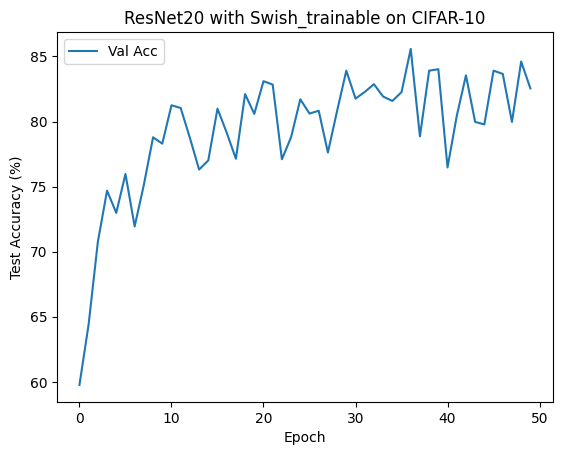

In [19]:
import matplotlib.pyplot as plt
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Test Accuracy (%)')
plt.title(f'{SELECT_MODEL} with {SELECT_ACTIVATION} on CIFAR-10')
plt.legend(); plt.show()

## Save Training History

Stores training logs (accuracy, loss, etc.) to Google Drive for future analysis or resumption.


Saved history to /content/drive/MyDrive/deep_learning_project/Swish_fixed/history_DenseNet121_Swish_fixed.pt


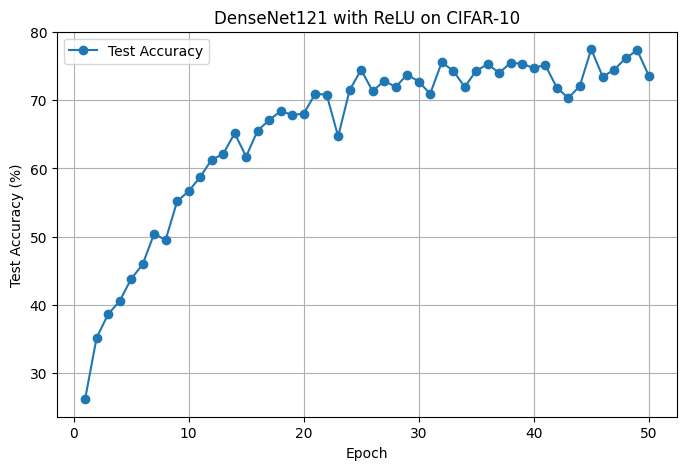

In [21]:
import torch, os

save_hist_path = os.path.join(
    BASE_DIR, SELECT_ACTIVATION,
    f"history_{SELECT_MODEL}_{SELECT_ACTIVATION}.pt"
)
torch.save(history, save_hist_path)
print("Saved history to", save_hist_path)
import torch
import os
import matplotlib.pyplot as plt

SELECT_MODEL       = 'DenseNet121'
SELECT_ACTIVATION  = 'ReLU'

hist_path = os.path.join(
    BASE_DIR, SELECT_ACTIVATION,
    f"history_{SELECT_MODEL}_{SELECT_ACTIVATION}.pt"
)

history = torch.load(hist_path)
test_acc_list = history.get('test_acc', history.get('val_acc'))


epochs = range(1, len(test_acc_list) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, test_acc_list, marker='o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title(f'{SELECT_MODEL} with {SELECT_ACTIVATION} on CIFAR-10')
plt.grid(True)
plt.legend()
plt.show()
